In [4]:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr
import os
import matplotlib.pyplot as plt
import matplotlib.colors as c
from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

plt.rc('text',usetex=True) 
plt.rc('xtick',color='dimgrey')
plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.sans-serif']=['Verdana']
plt.rcParams.update({'font.size': 12})
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
        # ax.tick_params(colors='red', axis='x') 
    else:
        ax.xaxis.set_ticks([]) 

import sys
sys.path.append(base_dir+'functions/')
from exp_hp import get_hp
from utils import split_retrain

In [5]:
# loading for lat lon information for plotting
ppath = '/glade/derecho/scratch/kjmayer/DATA/E3SMv2/PRECT/'
pfiname = 'PRECT_mem0101_7daymean_1950-2014_20S-20N_regrid2.5x2.5_polydetrend_allmems.nc'
X = xr.open_dataarray(ppath+pfiname)

lat = X.lat
lon = X.lon

In [6]:
EXP_NAME = 'exp2'
IG_dir = base_dir+'IG/data/'
entrycheck = 0
for SEED in range(10):
    ann1SDneg = np.load(IG_dir+'IG_ann_noshifttrain_'+EXP_NAME+'_negconf_seed'+str(SEED)+'.npy',allow_pickle = True)
    ann1SDpos = np.load(IG_dir+'IG_ann_noshifttrain_'+EXP_NAME+'_posconf_seed'+str(SEED)+'.npy',allow_pickle = True)
    if entrycheck == 0:
        IG_ann1SDneg = ann1SDneg
        IG_ann1SDpos = ann1SDpos
    else:
        IG_ann1SDneg = np.append(IG_ann1SDneg,ann1SDneg,axis = 0)
        IG_ann1SDpos = np.append(IG_ann1SDpos,ann1SDpos,axis = 0)
    entrycheck+=1

IG_ann1SDneg_mean = gaussian_filter(input=np.nanmean(IG_ann1SDneg,0), sigma = 0.75)
IG_ann1SDpos_mean = gaussian_filter(input=np.nanmean(IG_ann1SDpos,0), sigma = 0.75)

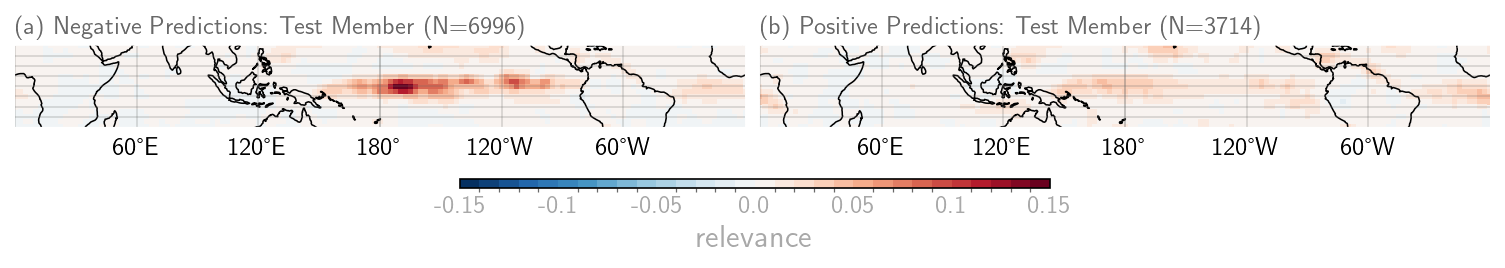

In [19]:
fig = plt.figure(figsize=(10.5,2.25))
ax = fig.subplot_mosaic('''
                        AB
                        ''',subplot_kw={'projection':ccrs.PlateCarree(180)})
plt.tight_layout(pad=2)
for loc in ['A','B']:   
    adjust_spines(ax[loc], ['bottom'])
    ax[loc].coastlines(resolution='110m', color='k', linewidth=.75)
    ax[loc].set_ylim(-20,20)
    ax[loc].axis("off")
    gl = ax[loc].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.2, color='dimgrey')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.bottom_labels = True
     
cmap = 'RdBu_r'
csm=plt.get_cmap(cmap)
norm = c.BoundaryNorm(np.arange(-0.15, 0.16, 0.01),csm.N)
    
c1 = ax['A'].pcolormesh(lon, lat, IG_ann1SDneg_mean,cmap=csm,transform=ccrs.PlateCarree(),norm=norm)
ax['A'].set_title('(a) Negative Predictions: Test Member (N='+str(IG_ann1SDneg.shape[0])+')',
                  fontsize=12,color='dimgrey',loc='left')

c1 = ax['B'].pcolormesh(lon, lat, IG_ann1SDpos_mean,cmap=csm,transform=ccrs.PlateCarree(),norm=norm)
ax['B'].set_title('(b) Positive Predictions: Test Member (N='+str(IG_ann1SDpos.shape[0])+')',
                  fontsize=12,color='dimgrey',loc='left')

cax2 = plt.axes([0.314,0.2,0.375,0.025]) # left, vertical, width, height
cbar2 = plt.colorbar(c1,cax=cax2,orientation = 'horizontal',fraction=0.04,
                         ticks=np.arange(-0.15, 0.2, 0.05))
cbar2.ax.set_xticklabels(np.round(np.arange(-0.15, 0.2, 0.05),3),color='darkgrey')
cbar2.ax.tick_params(size=0,labelsize=12)
cbar2.ax.set_xlabel('relevance',fontsize=15,color='darkgrey')

plt.show()
# plt.savefig('plots/IG_'+EXP_NAME+'_conf_'+sign_str+'preds.png', dpi=300, transparent = True, bbox_inches = 'tight')